In [1]:
import itertools
import pathlib
from typing import List

import msgspec

from yoshimidi.data.track import Track
input_file = pathlib.Path("~/Downloads/yoshimidi/dataset_parsed.jsonl").expanduser()

In [2]:
rows = []
with input_file.open("r") as f:
    for line in itertools.islice(f, 100):
        tracks = msgspec.json.decode(line, type=List[Track])
        for track in tracks:
            for channel in track.channels.values():
                for note, next_note in zip(channel.notes[:-1], channel.notes[1:], strict=True):
                    rows.append(next_note.time_secs - note.time_secs)

0.0007395485464276881


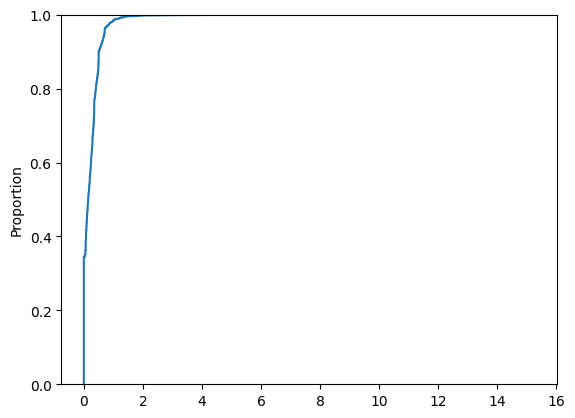

In [8]:
import seaborn as sns
import numpy as np
rows = np.array(rows)
# rows = np.sqrt(rows)
sns.ecdfplot(rows)
print((rows > 3).mean())